# Auto-cross-correlogram

In [4]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
#from fitting_functions import cross_validate_model
#from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmppk_bg8pe/cache.zip Bytes: 114474030


100%|██████████| 109.17094230651855/109.17094230651855 [00:34<00:00,  3.13it/s]


## Parameters

In [5]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [6]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [ ]:
a = session_trials.copy()
a['trial_duration'] = a['intervals_1'] - a['intervals_0']

(0.0, 10.0)

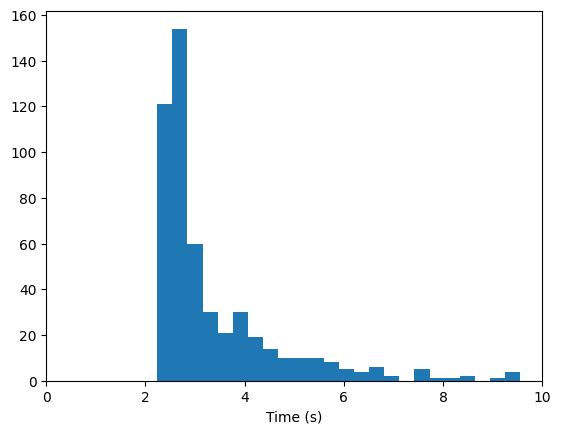

In [ ]:
plt.hist(a['trial_duration'], bins=200)
plt.xlabel('Time (s)')
plt.xlim([0, 10])

In [7]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

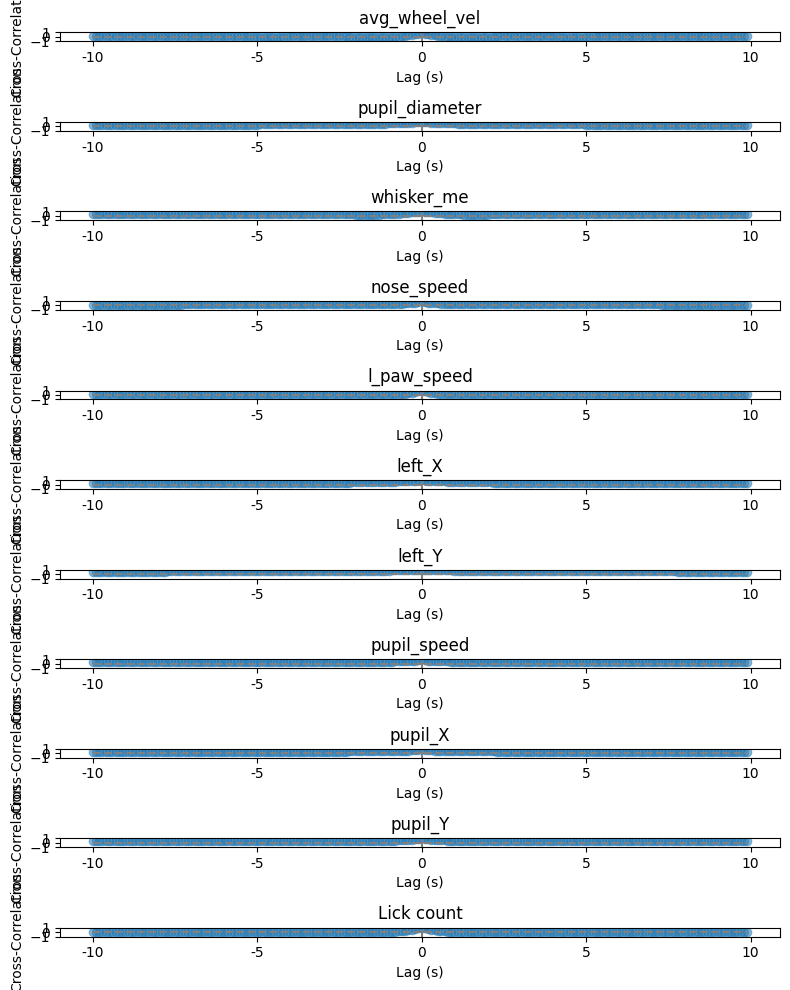

Text(0.5, 0, 'Time lag (s)')

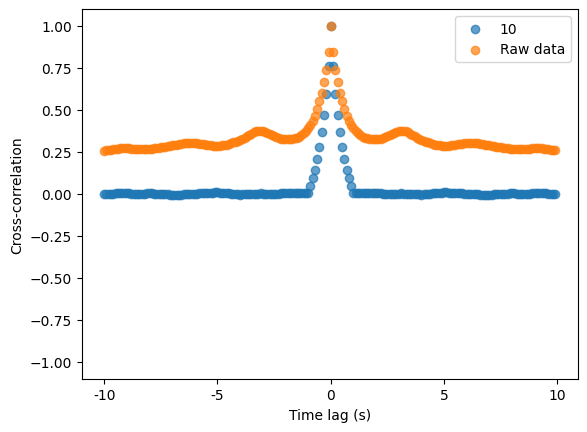

In [9]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# features = ['whisker_me', 'nose_speed', 'Lick count']

lags_to_plot = 100

chunk_sizes = [1, 2, 5, 10]
chunk_size = [1, 5]
chunk_size = [1]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [use_data.iloc[i:i + chunk_size] for i in range(0, len(use_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)

    corrs = []
    corrs_shuf = []

    if c == 0:
        # fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    

        fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 10])    
    for i, pc in enumerate(features):
        
        x = use_data[pc]
        x_shuf = shuffled_data[i]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        cross_correlation_shuf = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])
                
                x_chunk_shuf = np.array(x_shuf[-lag:])
                y_chunk_shuf = np.array(x_shuf[:lag])            
                
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

                x_chunk_shuf = np.array(x_shuf)
                y_chunk_shuf = np.array(x_shuf)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
                x_chunk_shuf = np.array(x_shuf[0:-lag])
                y_chunk_shuf = np.array(x_shuf[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            cross_correlation_shuf[l] = stats.pearsonr(x_chunk_shuf, y_chunk_shuf).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))
           
        # Plot the cross-correlation once 
        if c == 0:
            #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
            ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
            ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
            ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
            ax[i].set_xlabel('Lag (s)')
            ax[i].set_ylabel('Cross-Correlation')
            ax[i].set_title(pc)
            ax[i].set_ylim([-1, 1])
            ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
            plt.tight_layout()
plt.show()
    
plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size))    
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-1.1, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])


## Fit tau

The rate at which this autocorrelogram declines in a behaving mouse may be characterized as a time-constant, tau, of an exponentially decaying curve. Tau was fit using the Levenberg-Marquardt algorithm (non-linear least squares) using the SciPy optimization package.

In [11]:
features[var]

'Lick count'

2.2
7.2
3.1
2.7
2.6
7.9
2.8
3.0
3.3
2.9
3.2


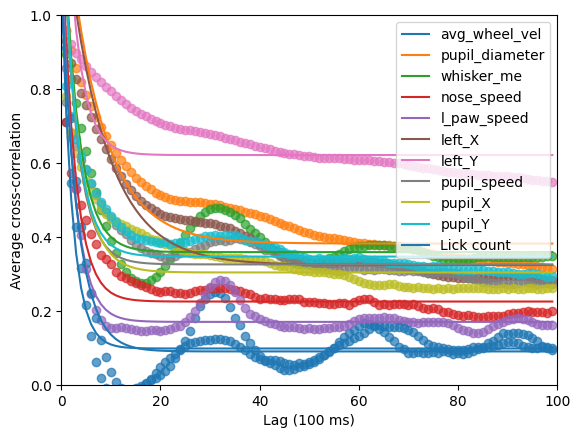

In [17]:
def func(t, tau, c):
    return np.exp(-t / tau) + c



for v, var in enumerate(range(np.shape(corrs)[0])):
    end = 1000
    t = lags[lags_to_plot:end]
    y = corrs[v, lags_to_plot:end]


    popt, pcov = curve_fit(func, t, y)

    tau, c = popt
    y_fit = func(t, tau, c)
    
    plt.scatter(lags[lags_to_plot:end], y, alpha=0.7)
    plt.plot(lags[lags_to_plot:end], y_fit, label=features[var])
    #plt.legend(str(np.round(tau, decimals=1)))
    plt.legend()
    print(np.round(tau, decimals=1))

    plt.ylim([0, 1])
    plt.xlabel('Lag (100 ms)')
    plt.ylabel('Average cross-correlation')
    plt.xlim([0, lags_to_plot])
    

(0.0, 100.0)

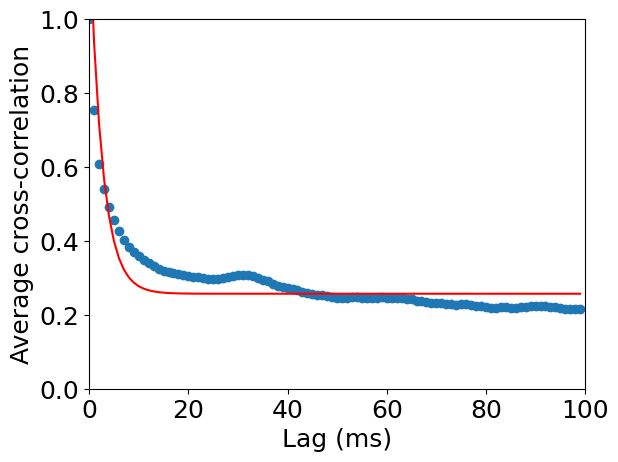

In [ ]:
plt.scatter(lags[100:end], np.mean(corrs, axis=0)[100:end])
plt.plot(lags[100:end], y_fit, color='Red')

plt.ylim([0, 1])
plt.xlabel('Lag (ms)')
plt.ylabel('Average cross-correlation')
plt.xlim([0, 100])


<Axes: title={'center': 'Correlation Matrix'}>

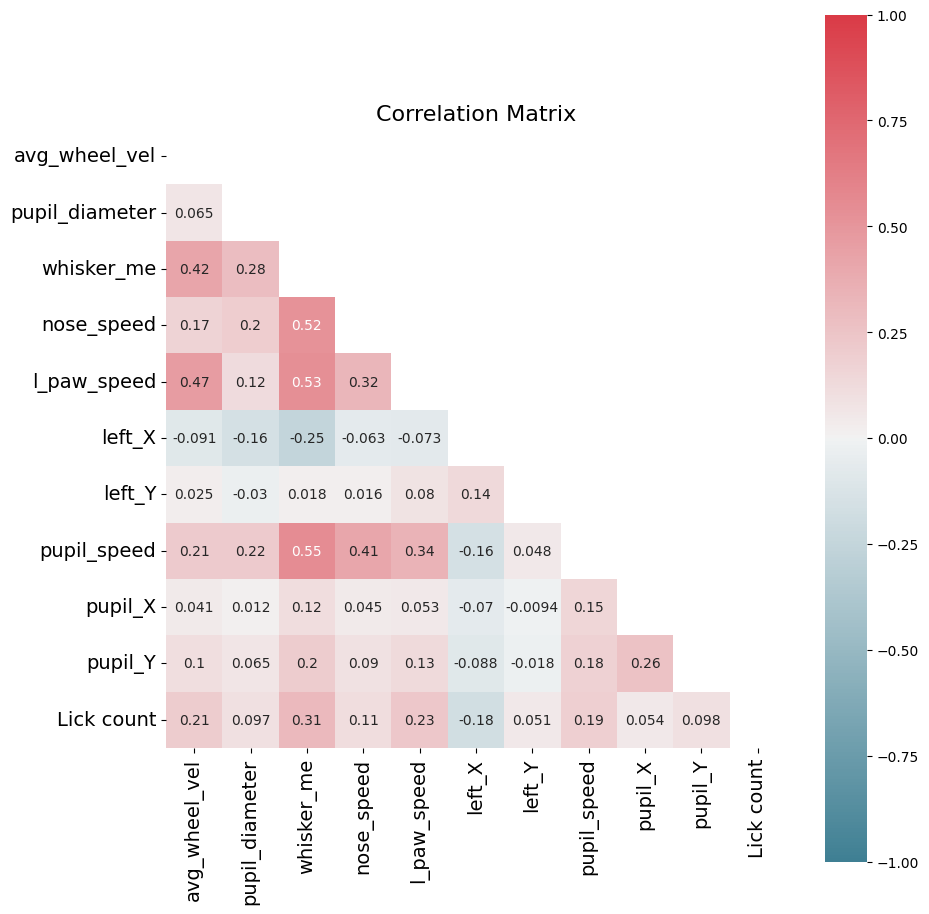

In [7]:
cov_df = use_data[var_names].dropna().drop_duplicates()
cov = cov_df.corr()
f = plt.figure(figsize=(10, 11))
plt.xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
plt.yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16)

matrix = np.triu(cov)

sns.heatmap(cov,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, annot=True, mask=matrix)

## PCA on data samples

In [4]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = matrix_all_unnorm[mat][0] # (n_samples, n_features)
#X = np.array(design_matrix)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


Text(0, 0.5, '% Variance explained')

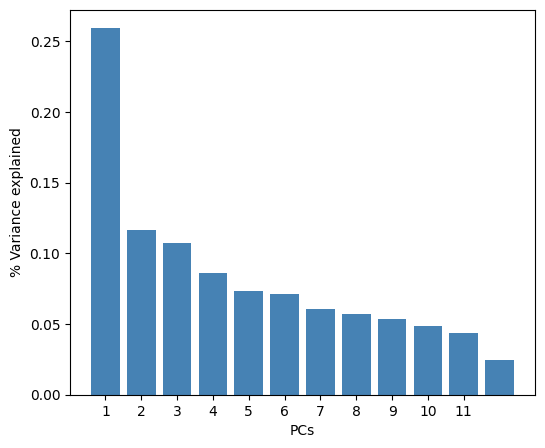

In [5]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

In [6]:
# Normalize PC projections
scaler = StandardScaler()

# Fit and transform the data
normalized_projections = scaler.fit_transform(X_reduced)  # TODO: is projections the accurate term here?
#normalized_projections = scaler.fit_transform(X)


### Get bin information

In [7]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['Bin'], index=range(len(normalized_projections)))
augmented_data['Bin'] = design_matrix['Bin']
augmented_data['pc1'] = normalized_projections[:, 0].transpose()
augmented_data['pc2'] = normalized_projections[:, 1].transpose()
augmented_data['pc3'] = normalized_projections[:, 2].transpose()
augmented_data['pc4'] = normalized_projections[:, 3].transpose()
augmented_data['pc5'] = normalized_projections[:, 4].transpose()
augmented_data['pc6'] = normalized_projections[:, 5].transpose()
augmented_data['pc7'] = normalized_projections[:, 6].transpose()
augmented_data['pc8'] = normalized_projections[:, 7].transpose()
augmented_data['pc9'] = normalized_projections[:, 8].transpose()
augmented_data['pc10'] = normalized_projections[:, 9].transpose()

Text(0.5, 0, 'Time lag (ms)')

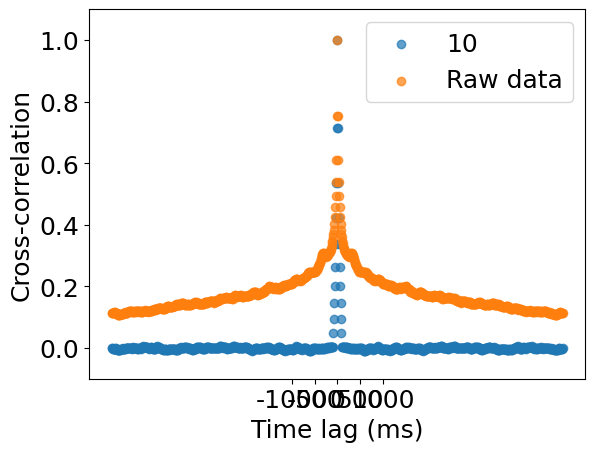

In [36]:
pcs = augmented_data.keys()[1:]
lags_to_plot = 500

chunk_sizes = [1, 2, 5, 10]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [augmented_data.iloc[i:i + chunk_size] for i in range(0, len(augmented_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)


    # fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])

    corrs = []
    corrs_shuf = []

    for i, pc in enumerate(pcs):
        
        x = augmented_data[pc]
        x_shuf = shuffled_data[i]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        cross_correlation_shuf = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])
                
                x_chunk_shuf = np.array(x_shuf[-lag:])
                y_chunk_shuf = np.array(x_shuf[:lag])            
                
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

                x_chunk_shuf = np.array(x_shuf)
                y_chunk_shuf = np.array(x_shuf)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
                x_chunk_shuf = np.array(x_shuf[0:-lag])
                y_chunk_shuf = np.array(x_shuf[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            cross_correlation_shuf[l] = stats.pearsonr(x_chunk_shuf, y_chunk_shuf).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))

#         # Plot the cross-correlation
#         ax[i].scatter(lags, cross_correlation, label='Raw data')
#         ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data')    
#         ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
#         ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
#         ax[i].set_xlabel('Lag')
#         ax[i].set_ylabel('Cross-Correlation')
#         ax[i].set_title(pc)
#         ax[i].set_ylim([0, 1])
                
#         plt.tight_layout()
# plt.show()
    
plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size))    
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-.1, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-1000, -500, 0, 500, 1000])
# Add labels and legend
plt.xlabel('Time lag (ms)')
#plt.xlim([0, 35])
